<div align='center'><font size="5" color='#353B47'>Predicting Stock Prices</font></div>

<br>
<hr>

<img src="https://toocooltrafficschool.com/wp-content/uploads/2019/02/what-is-tlsae740.png" width="500">

## <div id="summary">Summary</div>

**<font size="2"><a href="#chap1">1. Import libraries</a></font>**
**<br><font size="2"><a href="#chap2">2. Preprocessing</a></font>**
**<br><font size="2"><a href="#chap3">3. Build LSTM model</a></font>**
**<br><font size="2"><a href="#chap4">4. Training</a></font>**
**<br><font size="2"><a href="#chap5">5. Predictions</a></font>**

# <div id="chap1">1. Import libraries

In [11]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

# <div id="chap2">2. Preprocessing

In [12]:
def load_data(company, start, end):
    data = web.DataReader(company, 'yahoo', start, end)
    return data

In [13]:
# Company to be focused on: facebook
company = 'WIPRO.NS'

In [14]:
# data = load_data(company = company,
#                  start = dt.datetime(2012,1,1),
#                  end = dt.datetime(2019,1,1))



# import pandas_datareader as pdr
# import datetime as dt
 
# ticker = "WIPRO.NS"
# start = dt.datetime(2019, 1, 1)
# end = dt.datetime(2020, 12, 31)
 
# data = pdr.get_data_yahoo(ticker, start, end)
# print(data)

In [15]:
data= pd.read_csv("./WIPRO.NS.csv")

In [16]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [17]:
# how many days do i want to base my predictions on ?
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

# <div id="chap3">3. Build LSTM model

**<font color="blue" size="4">What is a LSTM ?</font>**

> Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. Introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work. They work tremendously well on a large variety of problems, and are now widely used.
>
> LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!
>
> All recurrent neural networks have the form of a chain of repeating modules of neural network.

You can find more details here: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [18]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

# <div id="chap4">4. Training

In [19]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [20]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

model.fit(x_train, 
          y_train, 
          epochs=25, 
          batch_size = 32,
          callbacks = [checkpointer])

Epoch 1/25
205/205 [==============================] - 23s 63ms/step - loss: nan
Epoch 2/25
205/205 [==============================] - 13s 64ms/step - loss: nan
Epoch 3/25
205/205 [==============================] - 13s 62ms/step - loss: nan
Epoch 4/25
205/205 [==============================] - 13s 62ms/step - loss: nan
Epoch 5/25
205/205 [==============================] - 13s 62ms/step - loss: nan
Epoch 6/25
205/205 [==============================] - 13s 61ms/step - loss: nan
Epoch 7/25
205/205 [==============================] - 13s 62ms/step - loss: nan
Epoch 8/25
205/205 [==============================] - 13s 61ms/step - loss: nan
Epoch 9/25
205/205 [==============================] - 13s 65ms/step - loss: nan
Epoch 10/25
205/205 [==============================] - 13s 62ms/step - loss: nan
Epoch 11/25
205/205 [==============================] - 13s 61ms/step - loss: nan
Epoch 12/25
205/205 [==============================] - 13s 61ms/step - loss: nan
Epoch 13/25
205/205 [================

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

In [26]:
model.save("model.h5")

# <div id="chap5">5. Predictions

In [27]:
# test model accuracy on existing data
test_data = data

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [28]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

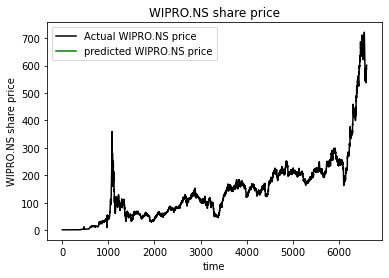

In [23]:
plt.plot(actual_prices, color='black', label=f"Actual {company} price")
plt.plot(predicted_prices, color= 'green', label=f"predicted {company} price")
plt.title(f"{company} share price")
plt.xlabel("time")
plt.ylabel(f"{company} share price")
plt.legend()
plt.show()

In [33]:
# predicting next day
real_data = [model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs+1),0]]

real_data = np.array(real_data)
print(real_data.shape)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))


(1, 59)


In [25]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"prediction: {prediction}")

ValueError: in user code:

    File "C:\Users\Amit Yadav\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Amit Yadav\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Amit Yadav\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Amit Yadav\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\Amit Yadav\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Amit Yadav\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 60, 1), found shape=(None, 59, 1)


**<font size="2"><a href="#summary">Back to summary</a></font>**

----

# References

* https://www.youtube.com/c/Neural

* https://www.kaggle.com/bryanb/introduction-to-time-series-analysis/edit/run/53321733

* http://colah.github.io/posts/2015-08-Understanding-LSTMs/

<hr>
<br>
<div align='justify'><font color="#353B47" size="4">Thank you for taking the time to read this notebook. I hope that I was able to answer your questions or your curiosity and that it was quite understandable. <u>any constructive comments are welcome</u>. They help me progress and motivate me to share better quality content. I am above all a passionate person who tries to advance my knowledge but also that of others. If you liked it, feel free to <u>upvote and share my work.</u> </font></div>
<br>
<div align='center'><font color="#353B47" size="3">Thank you and may passion guide you.</font></div>